<a href="https://colab.research.google.com/github/DorodiK/sentiment_analysis/blob/main/Sentiment_Analysis_Model_Pretrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Cloning the GitHub repository 

In [1]:
!git clone https://github.com/DorodiK/sentiment_analysis

Cloning into 'sentiment_analysis'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [2]:
#import libraries 
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
import plotly.express as px
import plotly as pl
import datetime

#import NLP libraries
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix


nltk.download('wordnet')
print('Done')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Done


##Loading Datasest

In [3]:
!ls sentiment_analysis/

Sentiment_Analysis_Model_Pretrain.ipynb  train.csv  vaccination_all_tweets.csv


In [4]:
#load dataset - Tweet Sentiment Extraction
datadir = "sentiment_analysis"
train = pd.read_csv(os.path.join(datadir, 'train.csv'))
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
train.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [7]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [8]:
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


In [9]:
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [10]:
if (train["selected_text"].isnull().sum() > 0):
    train["selected_text"].fillna("No content", inplace = True)

##Data Preprocessing 

####**Issues with the selected text** - urls, uppercase, lowercase, punctuation signs, new lines, stopwords. 

In [11]:
def preproces_data(data):
  #removing URLs with a regular expression 
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  data = url_pattern.sub(r'', data)

  #remove emails 
  data = re.sub('\S*@\S*\s?', '', data)

  #remove new line characters 
  data = re.sub('\s+', '', data)

  #remove distracting single quotes 
  data = re.sub("\'", "", data)

  return data 



In [12]:
temp = []
#pd series to list 

data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
  n = preproces_data(data_to_list[i])
  temp.append(n)
list(temp[:20])

['I`dhaveresponded,ifIweregoing',
 'SoooSAD',
 'bullyingme',
 'leavemealone',
 'Sonsof****,',
 '-someshamelesspluggingforthebestRangersforumonearth',
 'fun',
 'Soooohigh',
 'Bothofyou',
 'Wow...ujustbecamecooler.',
 'asmuchasilovetobehopeful,ireckonthechancesareminimal=Pi`mnevergonnagetmycakeandstuff',
 'like',
 'DANGERously',
 'lost',
 'testtestfromtheLGenV2',
 'Uhoh,Iamsunburned',
 '*sigh*',
 'sick',
 'onna',
 'Hesjustnotthatintoyou']

###Detokenization, Stemming and Lemmatization

In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])


def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)
    
data = []
for i in range(len(data_words)):
    
    #for j in range(len(data_words[i])):
        #stemming
        #data_words[i][j] = lancaster.stem(data_words[i][j])
        #lemmatization
        #data_words[i][j] = data_words[i][j].format(data_words[i][j],wordnet_lemmatizer.lemmatize(data_words[i][j]))
    
    data.append(detokenize(data_words[i]))
print(data[:10])

[['dhaveresponded', 'ifiweregoing'], ['sooosad'], ['bullyingme'], ['leavemealone'], ['sonsof'], [], ['fun'], ['soooohigh'], ['bothofyou'], ['wow']]
['dhaveresponded ifiweregoing', 'sooosad', 'bullyingme', 'leavemealone', 'sonsof', '', 'fun', 'soooohigh', 'bothofyou', 'wow']


In [18]:
data = np.array(data)

### Label encoding 

In [19]:
#Define class labels 

labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

### Data sequencing and splitting
[Reference used for code](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [21]:
max_words = 5000
max_len = 200   

#Prepare tokenizer 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)

#encoded docs 

tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    0 2224 1143]
 [   0    0    0 ...    0    0  769]
 [   0    0    0 ...    0    0 2225]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0 2223]
 [   0    0    0 ...    0   27  129]]


In [22]:
print(labels.shape)
print(tweets.shape)

(27481, 3)
(27481, 200)


In [25]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


### Pretrained GloVe Embedding (experimental)
[Reference for the code modified](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

In [147]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(data)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(data)



max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs.shape)

(145025, 200)


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(padded_docs,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [ ]:
#Define model 
from keras.layers import Embedding, Dense, Flatten


model0 = Sequential()
e = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)
model0.add(e)
model0.add(Flatten())
model0.add(Dense(3, activation='softmax'))



print(model0.summary())
plot_model(model0, to_file='model0-lstm.png')


#compile model 
model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

# fit the model
model0.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          3414000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 120003    
Total params: 3,534,003
Trainable params: 120,003
Non-trainable params: 3,414,000
_________________________________________________________________
None
645/645 [==============================] - 15s 11ms/step - loss: 0.9446 - accuracy: 0.5756 - val_loss: 0.8457 - val_accuracy: 0.6037


In [ ]:
#Define LSTM model 

model1 = Sequential()
e = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)
model1.add(e)
model0.add(Flatten())
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

print(model1.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 200)          3414000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                12960     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 48        
Total params: 3,427,008
Trainable params: 13,008
Non-trainable params: 3,414,000
_________________________________________________________________
None


In [ ]:
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint1])

645/645 [==============================] - 64s 96ms/step - loss: 1.0895 - accuracy: 0.4019 - val_loss: 1.0888 - val_accuracy: 0.3979

Epoch 00001: val_accuracy improved from -inf to 0.39790, saving model to best_model1.hdf5


In [ ]:
# Define bi-directional LSTM 
model2 = Sequential()
e = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)
model2.add(e)
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))

print(model2.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 200)          3414000   
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                35360     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 123       
Total params: 3,449,483
Trainable params: 35,483
Non-trainable params: 3,414,000
_________________________________________________________________
None


In [ ]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint2])

645/645 [==============================] - 112s 165ms/step - loss: 0.9856 - accuracy: 0.5330 - val_loss: 0.8417 - val_accuracy: 0.5996

Epoch 00001: val_accuracy improved from -inf to 0.59962, saving model to best_model2.hdf5


In [ ]:
#Define 1D CNN
from keras import regularizers

model3 = Sequential()
e = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)
model3.add(e)
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))

print(model3.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 200)          3414000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 20)           24020     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 20)            2420      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 63        
Total params: 3,440,503
Trainable params: 26,503
Non-trainable params: 3,414,000
______________________________________

In [ ]:
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint3])

645/645 [==============================] - 35s 50ms/step - loss: 1.3560 - acc: 0.5179 - val_loss: 0.9848 - val_acc: 0.5934


###Model Building





### Single LSTM

In [45]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.2))
model1.add(layers.Dense(3,activation='softmax'))

print(model1.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 20)          100000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 15)                2160      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 48        
Total params: 102,208
Trainable params: 102,208
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint1])

645/645 [==============================] - 55s 80ms/step - loss: 1.0591 - accuracy: 0.4300 - val_loss: 0.9136 - val_accuracy: 0.5730

Epoch 00001: val_accuracy improved from -inf to 0.57299, saving model to best_model1.hdf5


### Bi-Directional LSTM

In [50]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(15,dropout=0.2)))
model2.add(layers.Dense(3,activation='softmax'))


In [51]:
print(model2.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 40)           200000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30)                6720      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 93        
Total params: 206,813
Trainable params: 206,813
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#model2 = keras.models.load_model('./best_model2.hdf5')
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint2])

645/645 [==============================] - 88s 129ms/step - loss: 1.0545 - accuracy: 0.4467 - val_loss: 0.9046 - val_accuracy: 0.5765

Epoch 00001: val_accuracy improved from -inf to 0.57648, saving model to best_model2.hdf5


###1D CNN

In [34]:
from keras import regularizers
#,kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu'))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu'))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))


In [35]:
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 20)           4820      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 20)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 20)            2420      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 207,303
Trainable params: 207,303
Non-trainable params: 0
________________________________________________

###Multichannel CNN


In [57]:
from keras import regularizers
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.models import Model

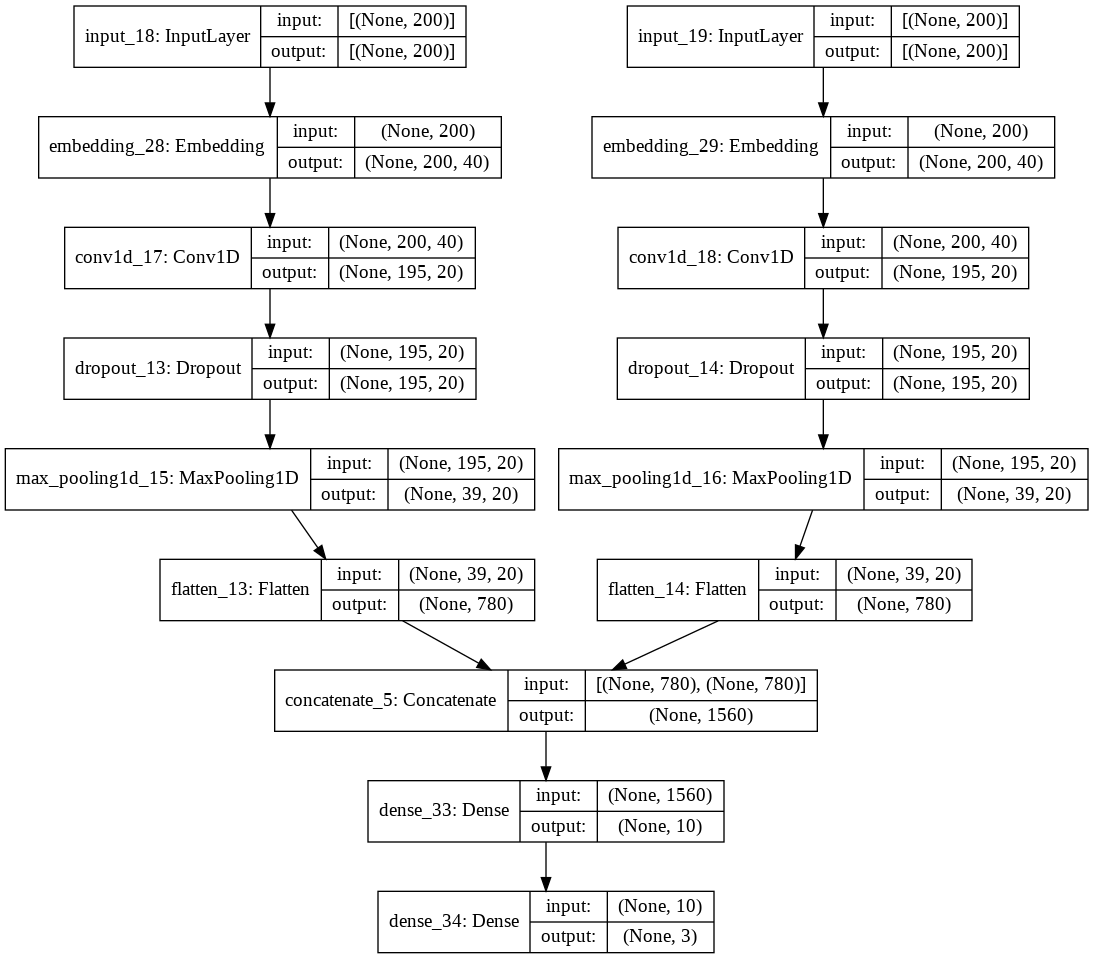

In [82]:
  #channel 1
  inputn = Input(shape=(max_len,))
  embdn = Embedding(max_words, 40)(inputn)
  convn = Conv1D(20, 6, activation='relu')(embdn)
  dropn = Dropout(0.2)(convn)
  pooln = MaxPooling1D(5)(dropn)
  flatn = Flatten()(pooln)

  #channel 2
  inputm = Input(shape=(max_len,))
  embdm = Embedding(max_words, 40)(inputm)
  convm = Conv1D(20, 6, activation='relu')(embdm)
  dropm = Dropout(0.2)(convm)
  poolm = MaxPooling1D(5)(dropm)
  flatm = Flatten()(poolm)

      #merge 
  merged1 = concatenate([flatn, flatm])
  
  #Interpretation 
  dense2 = Dense(10, activation='relu')(merged1)
  outputs = Dense(3,activation='softmax')(dense2)

  model7 = Model(inputs=[inputn, inputm],outputs=outputs)

  plot_model(model7, show_shapes=True, to_file='model7.png')

In [83]:
model7.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
checkpoint7 = ModelCheckpoint("best_model55.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model7.fit([X_train, X_train], y_train, epochs=1, validation_data=([X_test,X_test],y_test), callbacks=checkpoint7)

645/645 [==============================] - 110s 39ms/step - loss: 1.0620 - acc: 0.4241 - val_loss: 0.8229 - val_acc: 0.6203


### Sentiment Analysis -Random

In [84]:
test = [X_test,X_test]

test_loss, test_acc = model7.evaluate(test, y_test, verbose=2)

215/215 - 1s - loss: 0.8229 - acc: 0.6203


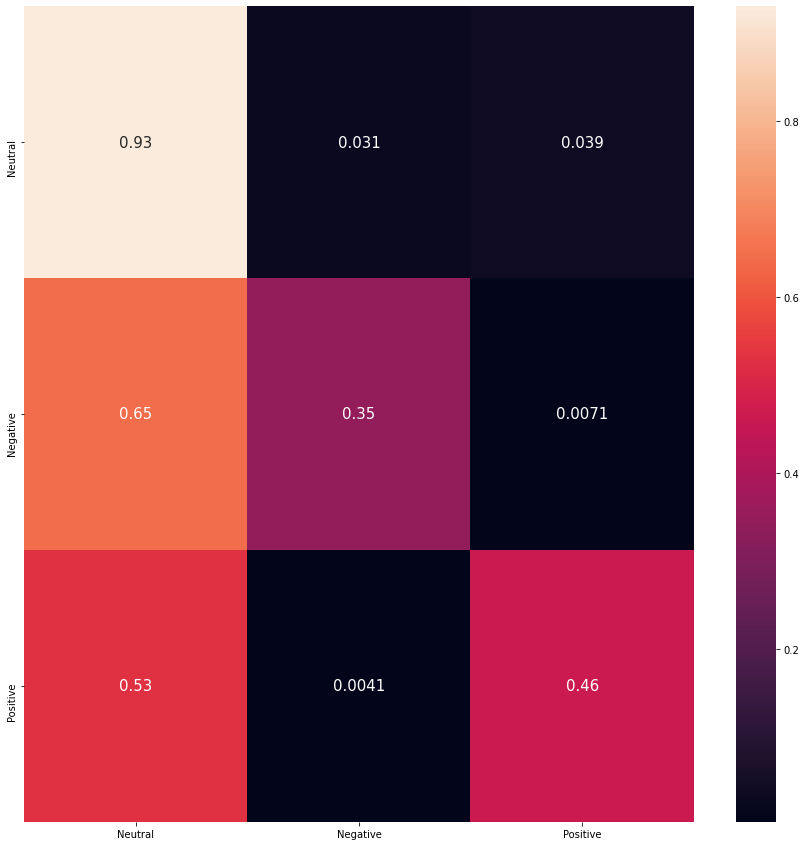

In [86]:
x = [X_test, X_test]
predictions = model7.predict(x)
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [92]:
sentiment = ['Neutral','Negative','Positive']

In [94]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test3 = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model7.predict([test3,test3]), decimals=0).argmax(axis=1)[0]]

'Negative'

In [95]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test2 = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model7.predict([test2, test2]), decimals=0).argmax(axis=1)[0]]

'Positive'

In [97]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test4 = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model7.predict([test4, test4]), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [99]:
sequence = tokenizer.texts_to_sequences(['the trump administration failed to deliver on vaccine promises shocker covidiots coronavirus covidvaccine'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model7.predict([test,test]), decimals=0).argmax(axis=1)[0]]

'Neutral'

###Multichannel bi-directional LSTM

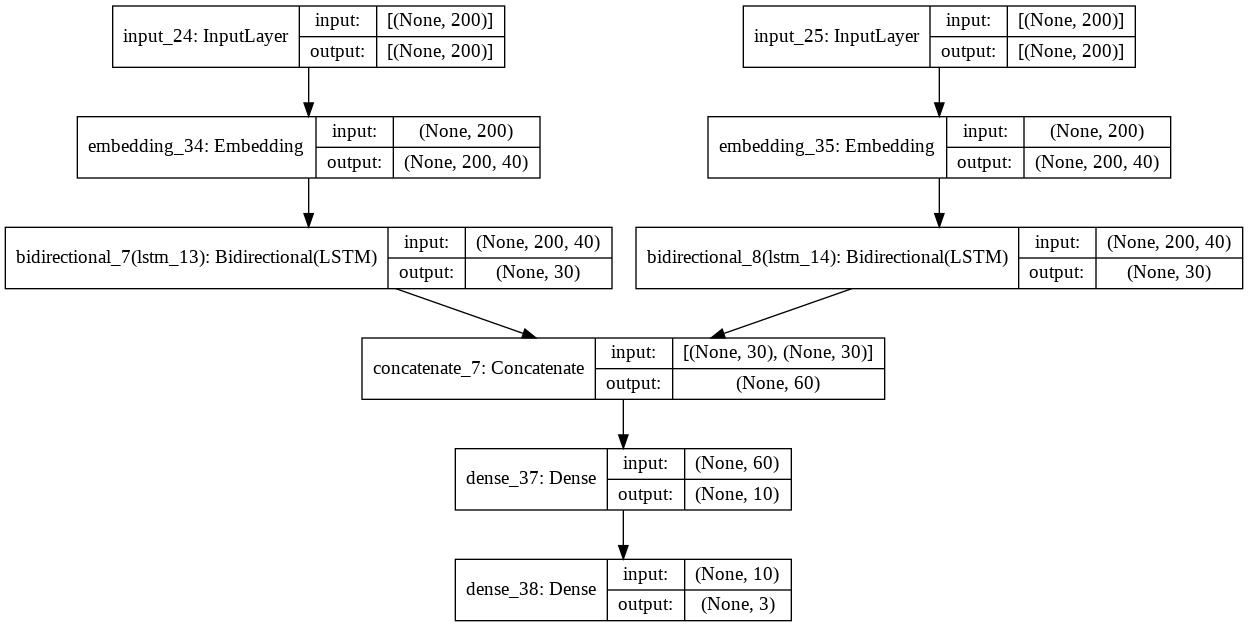

In [114]:
from keras.layers import Bidirectional
#channel 1
input5 = Input(shape=(max_len,))
embd5 = Embedding(max_words, 40)(input5)
bilstm5 = Bidirectional(layers.LSTM(15,dropout=0.2))(embd5)

#channel 2
input6 = Input(shape=(max_len,))
embd6 = Embedding(max_words, 40)(input6)
bilstm6 = Bidirectional(layers.LSTM(15,dropout=0.2))(embd6)

#merge 
merged5 = concatenate([bilstm5, bilstm6])

#Interpretation 
dense5 = Dense(10, activation='relu')(merged5)
outputs = Dense(3,activation='softmax')(dense5)

model9 = Model(inputs=[input5, input6],outputs=outputs)

plot_model(model9, show_shapes=True, to_file='model9.png')



In [115]:

model9.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
checkpoint9 = ModelCheckpoint("best_model9.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
input_tensor = [X_train, X_train]
history = model9.fit(input_tensor, y_train, epochs=1, validation_data=([X_test,X_test],y_test), callbacks=checkpoint9)

645/645 [==============================] - 166s 244ms/step - loss: 1.0386 - acc: 0.4529 - val_loss: 0.8415 - val_acc: 0.6258


### Sentiment Analysis - Random

In [117]:
test = [X_test,X_test]

test_loss, test_acc = model9.evaluate(test, y_test, verbose=2)

215/215 - 8s - loss: 0.8415 - acc: 0.6258


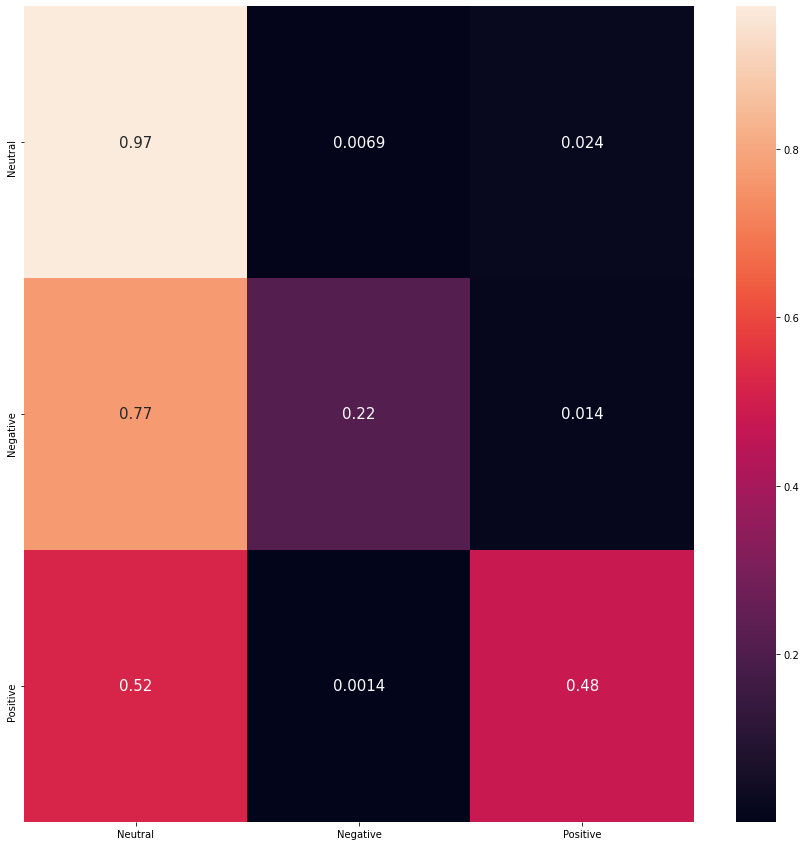

In [118]:
x = [X_test, X_test]
predictions = model9.predict(x)
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

###Multichannel LSTM

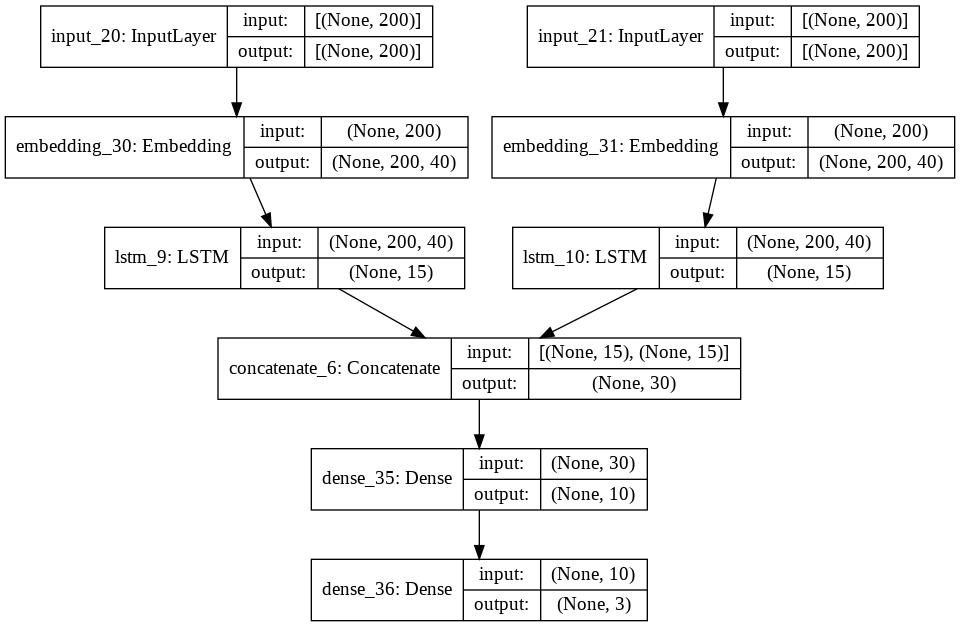

In [102]:
from keras.layers import LSTM 
#channel 1
input3 = Input(shape=(max_len,))
embd3 = Embedding(max_words, 40)(input3)
lstm3 = LSTM(15,dropout=0.2)(embd3)

#channel 2
input4 = Input(shape=(max_len,))
embd4 = Embedding(max_words, 40)(input4)
lstm4 = LSTM(15,dropout=0.2)(embd4)

#merge 
merged1 = concatenate([lstm3, lstm4])

#Interpretation 
dense2 = Dense(10, activation='relu')(merged1)
outputs = Dense(3,activation='softmax')(dense2)

model8 = Model(inputs=[input3, input4],outputs=outputs)

plot_model(model8, show_shapes=True, to_file='model8.png')

In [103]:

model8.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
checkpoint8 = ModelCheckpoint("best_model8.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
input_tensor = [X_train, X_train]
history = model8.fit(input_tensor, y_train, epochs=1, validation_data=([X_test,X_test],y_test), callbacks=checkpoint8)

645/645 [==============================] - 86s 127ms/step - loss: 1.0091 - acc: 0.4894 - val_loss: 0.7916 - val_acc: 0.6423


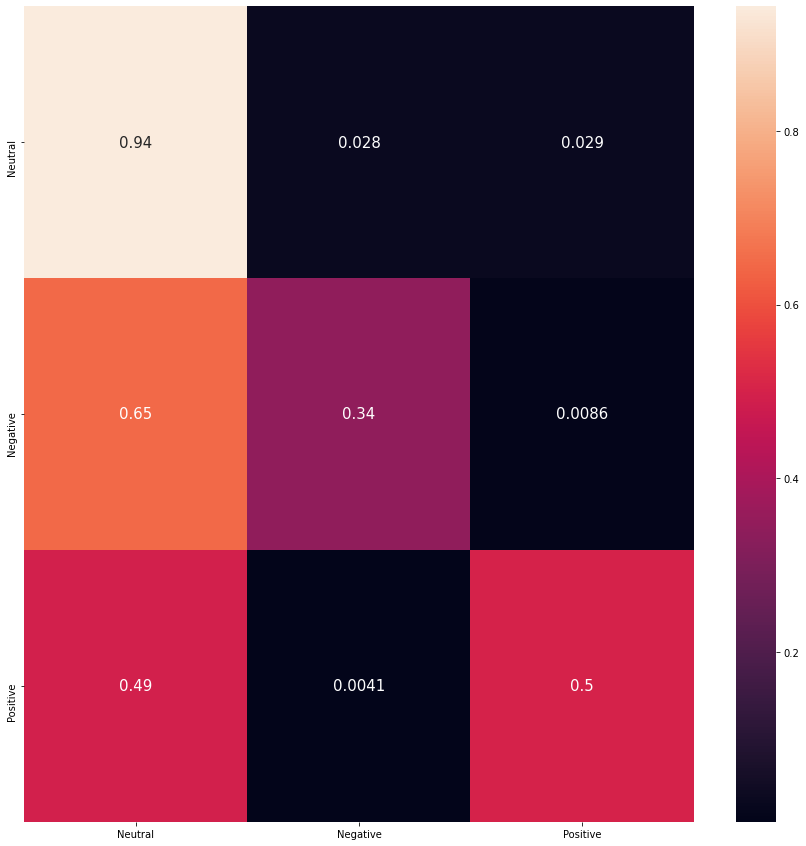

In [104]:
x = [X_test, X_test]
predictions = model8.predict(x)
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
seaborn.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

###Sentiment Analysis - Random

In [105]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test4 = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model8.predict([test4, test4]), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [106]:
sequence = tokenizer.texts_to_sequences(['the trump administration failed to deliver on vaccine promises shocker covidiots coronavirus covidvaccine'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model8.predict([test,test]), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [108]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test2 = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model8.predict([test2, test2]), decimals=0).argmax(axis=1)[0]]

'Positive'

In [109]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test3 = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model8.predict([test3,test3]), decimals=0).argmax(axis=1)[0]]

'Negative'

### Hyperparameter tuning (Experimental)

In [ ]:
#Import libraries

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier

#1D CNN Model 
def create_model(dropout_rate=0.0):
	# create model
  model3 = Sequential()
  model3.add(Embedding(max_words, 40, input_length=max_len))
  model3.add(Conv1D(20, 6, activation='relu'))
  model3.add(MaxPooling1D(5))
  model3.add(Conv1D(20, 6, activation='relu'))
  model3.add(Dropout(dropout_rate))
  model3.add(GlobalMaxPooling1D())
  model3.add(Dense(3,activation='softmax'))
	# Compile model
  model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
  return model3


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset

# create model
model = KerasClassifier(build_fn=create_model, epochs=5, verbose=2)

dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)



# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/5
645/645 - 13s - loss: 0.9910 - acc: 0.4962
Epoch 2/5
645/645 - 12s - loss: 0.8206 - acc: 0.6291
Epoch 3/5
645/645 - 12s - loss: 0.7678 - acc: 0.6655
Epoch 4/5
645/645 - 12s - loss: 0.7352 - acc: 0.6846
Epoch 5/5
645/645 - 12s - loss: 0.7157 - acc: 0.6948
Best: 0.632703 using {'dropout_rate': 0.2}
0.630665 (0.009527) with: {'dropout_rate': 0.0}
0.631781 (0.003245) with: {'dropout_rate': 0.1}
0.632703 (0.002703) with: {'dropout_rate': 0.2}
0.631732 (0.008154) with: {'dropout_rate': 0.3}
0.626880 (0.004857) with: {'dropout_rate': 0.4}
0.628627 (0.008971) with: {'dropout_rate': 0.5}
0.628869 (0.004907) with: {'dropout_rate': 0.6}
0.621883 (0.014018) with: {'dropout_rate': 0.7}
0.568947 (0.072960) with: {'dropout_rate': 0.8}
0.544639 (0.013431) with: {'dropout_rate': 0.9}


### Covid-19 Vaccine Tweet Dataset 

In [110]:
#Load data 

covidtweets = pd.read_csv(os.path.join(datadir, 'vaccination_all_tweets.csv'))
covidtweets.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False


###Preprocessing 

In [119]:
temp = []
#Splitting pd.Series to list
data_to_list = covidtweets["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(preproces_data(data_to_list[i]))
list(temp[:5])


data_words = list(sent_to_words(temp))
print(data_words[:10])


data = []
for i in range(len(data_words)):
    
    #for j in range(len(data_words[i])):
        #stemming
        #data_words[i][j] = lancaster.stem(data_words[i][j])
        #lemmatization
        #data_words[i][j] = data_words[i][j].format(data_words[i][j],wordnet_lemmatizer.lemmatize(data_words[i][j]))
        
    data.append(detokenize(data_words[i]))
print(data[:5])

data = np.array(data)

#adding empty sentiment column
covidtweets["sentiment"] = np.nan

[['pfizerbiontech'], ['hopefully'], ['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_', 'years'], ['senator', 'youwereborni'], ['pfizerbiontech'], [], ['canada', 'ukand'], ['election'], ['covidvaccine', 'yougettingit', 'covidvaccine', 'covid', 'pfizerbiontech', 'moderna'], ['covid', 'vaccinemonday', 'ussays', 'pakustv', 'nyc', 'healthcare', 'globalgoals']]
['pfizerbiontech', 'hopefully', 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ years', 'senator youwereborni', 'pfizerbiontech']


### Applying multichannel cnn to covid-19 vaccine tweets dataset

In [120]:
#covidtweets["sentiment"] = best_model.predict_classes(data)]
for i in range(len(temp)):
    sequence = tokenizer.texts_to_sequences([temp[i]])
    test = pad_sequences(sequence, maxlen=max_len)
    covidtweets["sentiment"][i] = sentiment[np.around(model8.predict([test, test]), decimals=0).argmax(axis=1)[0]]
    if (i % 461 == 0):
        percentage = i/len(temp) * 100
        formatted_percentage = "{:.0f}".format(percentage)
        print(formatted_percentage,"%")

0 %
0 %
1 %
1 %
1 %
2 %
2 %
2 %
3 %
3 %
3 %
3 %
4 %
4 %
4 %
5 %
5 %
5 %
6 %
6 %
6 %
7 %
7 %
7 %
8 %
8 %
8 %
9 %
9 %
9 %
10 %
10 %
10 %
10 %
11 %
11 %
11 %
12 %
12 %
12 %
13 %
13 %
13 %
14 %
14 %
14 %
15 %
15 %
15 %
16 %
16 %
16 %
17 %
17 %
17 %
17 %
18 %
18 %
18 %
19 %
19 %
19 %
20 %
20 %
20 %
21 %
21 %
21 %
22 %
22 %
22 %
23 %
23 %
23 %
24 %
24 %
24 %
24 %
25 %
25 %
25 %
26 %
26 %
26 %
27 %
27 %
27 %
28 %
28 %
28 %
29 %
29 %
29 %
30 %
30 %
30 %
31 %
31 %
31 %
31 %
32 %
32 %
32 %
33 %
33 %
33 %
34 %
34 %
34 %
35 %
35 %
35 %
36 %
36 %
36 %
37 %
37 %
37 %
38 %
38 %
38 %
38 %
39 %
39 %
39 %
40 %
40 %
40 %
41 %
41 %
41 %
42 %
42 %
42 %
43 %
43 %
43 %
44 %
44 %
44 %
45 %
45 %
45 %
45 %
46 %
46 %
46 %
47 %
47 %
47 %
48 %
48 %
48 %
49 %
49 %
49 %
50 %
50 %
50 %
51 %
51 %
51 %
51 %
52 %
52 %
52 %
53 %
53 %
53 %
54 %
54 %
54 %
55 %
55 %
55 %
56 %
56 %
56 %
57 %
57 %
57 %
58 %
58 %
58 %
58 %
59 %
59 %
59 %
60 %
60 %
60 %
61 %
61 %
61 %
62 %
62 %
62 %
63 %
63 %
63 %
64 %
64 %
64 %
65 %
65 %
65 %


#### Model time to train - 2 hours

In [121]:
pd.set_option('display.max_colwidth', None)
covidtweets[["text", "sentiment"]].head(50)

,text,sentiment
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,Neutral
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Positive
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,Neutral
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",Neutral
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,Neutral
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,Neutral
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",Neutral
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,Neutral
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,Neutral
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",Neutral


### Plotting charts for the sentiment distribution

  sentiment  tweets
0  Negative     821
1   Neutral  140481
2  Positive    3723


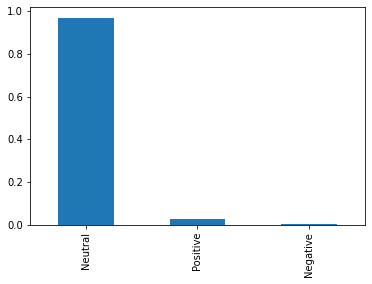

In [122]:
# Plot sentiment value counts
covidtweets['sentiment'].value_counts(normalize=True).plot.bar();

timeline = covidtweets.groupby(['sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='sentiment', y="tweets", color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

In [123]:
# Convert dates
covidtweets['date'] = pd.to_datetime(covidtweets['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = covidtweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"], category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()


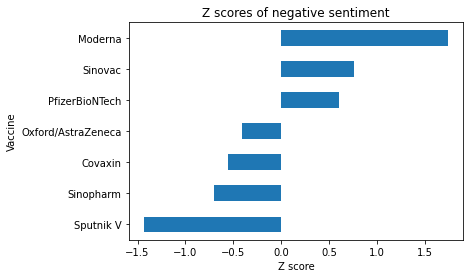

In [124]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(covidtweets, ['covaxin'], title='Covaxin')
sinovac = filtered_timeline(covidtweets, ['sinovac'], title='Sinovac')
sinopharm = filtered_timeline(covidtweets, ['sinopharm'], title='Sinopharm')
moderna = filtered_timeline(covidtweets, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(covidtweets, ['sputnik'], title='Sputnik V')
oxford = filtered_timeline(covidtweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')
pfizer = filtered_timeline(covidtweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sputnik V': sputnikv, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative', 'Neutral', 'Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

### Old Results - Delete

  sentiment  tweets
0  Negative    1266
1   Neutral  140668
2  Positive    3091


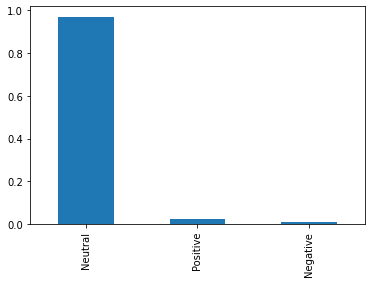

In [ ]:
# Plot sentiment value counts
covidtweets['sentiment'].value_counts(normalize=True).plot.bar();

timeline = covidtweets.groupby(['sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
print(timeline)
fig = px.bar(timeline,
            x='sentiment', y="tweets", color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"]
        )
fig.show()

In [ ]:
# Convert dates
covidtweets['date'] = pd.to_datetime(covidtweets['date'], errors='coerce').dt.date

# Get counts of number of tweets by sentiment for each date
timeline = covidtweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', color_discrete_sequence=["#EF553B", "#636EFA", "#00CC96"], category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

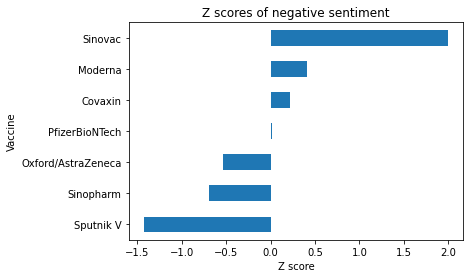

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(covidtweets, ['covaxin'], title='Covaxin')
sinovac = filtered_timeline(covidtweets, ['sinovac'], title='Sinovac')
sinopharm = filtered_timeline(covidtweets, ['sinopharm'], title='Sinopharm')
moderna = filtered_timeline(covidtweets, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(covidtweets, ['sputnik'], title='Sputnik V')
oxford = filtered_timeline(covidtweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')
pfizer = filtered_timeline(covidtweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sputnik V': sputnikv, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['Negative', 'Neutral', 'Positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('Negative_zscore')['Negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

### Word clouds

[Reference for code repurposed](https://www.kaggle.com/pawanbhandarkar/generate-smarter-word-clouds-with-log-likelihood#Smarter-Word-Clouds)

#####Code

In [125]:
!pip install wordninja pyspellchecker
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")
import math
import random

     |████████████████████████████████| 541 kB 4.2 MB/s 
     |████████████████████████████████| 2.7 MB 22.2 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=9ee7c5148310af0f5b6f4ac5346fee2c071d58ae9d518bd6e06951aacad352d4
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [126]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

#####Visualisation

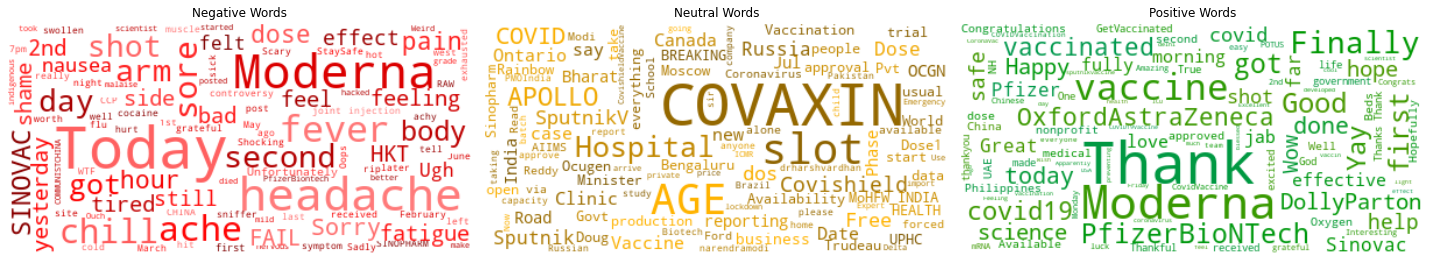

In [146]:
# Convert string to a list of words
covidtweets['words'] = covidtweets.text.apply(lambda x:re.findall(r'\w+', x ))

def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='Negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='Positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='Neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
get_smart_clouds(covidtweets)